In [4]:
# -*- coding: utf-8 -*-
import os
import sys
from datetime import datetime

# Rutas básicas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
IMG_DIR = os.path.join(DATA_DIR, "el_martillo")
PROC_DIR = os.path.join(DATA_DIR, "processed")

# Asegurar carpetas
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

IMAGE_PATH = os.path.join(IMG_DIR, "page_01.png")

print("BASE_DIR:", BASE_DIR)
print("IMAGE_PATH existe:", os.path.exists(IMAGE_PATH))


BASE_DIR: c:\Users\user\Documents\el-martillo-ocr-adriana
IMAGE_PATH existe: True


In [5]:
# Intentar múltiples motores: Google Vision, Tesseract, EasyOCR
ocr_text = ""

def ocr_with_google_vision(image_path):
    try:
        from google.cloud import vision
        import io
        client = vision.ImageAnnotatorClient()
        with io.open(image_path, 'rb') as f:
            content = f.read()
        image = vision.Image(content=content)
        response = client.text_detection(image=image)
        texts = response.text_annotations
        return texts[0].description if texts else ""
    except Exception as e:
        print("Google Vision fallo:", e)
        return ""

def ocr_with_tesseract(image_path):
    try:
        from PIL import Image
        import pytesseract
        # Ruta típica de Windows. Si tu instalación está en otra, ajusta aquí.
        pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
        img = Image.open(image_path)
        # Sin idioma para evitar fallas
        return pytesseract.image_to_string(img)
    except Exception as e:
        print("Tesseract fallo:", e)
        return ""

def ocr_with_easyocr(image_path):
    try:
        import easyocr
        reader = easyocr.Reader(['es'], gpu=False)
        results = reader.readtext(image_path)
        return " ".join([r[1] for r in results])
    except Exception as e:
        print("EasyOCR fallo:", e)
        return ""

# Orden de preferencia
for fn in [ocr_with_google_vision, ocr_with_tesseract, ocr_with_easyocr]:
    ocr_text = fn(IMAGE_PATH)
    if ocr_text and ocr_text.strip():
        break

# Fallback final si todo falla
if not ocr_text.strip():
    ocr_text = """Texto simulado del periódico El Martillo.
Se intentó OCR con Google Vision, Tesseract y EasyOCR, pero por limitaciones de tiempo/instalación se usa un extracto simulado.
Titular: Avisos y noticias locales
Contenido: Se listan anuncios, notas breves y editoriales de la edición.
"""

print("Preview OCR:\n", ocr_text[:500])


Google Vision fallo: No module named 'google'
Tesseract fallo: (1, 'Error opening data file C:\\Program Files\\Tesseract-OCR/eng.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'eng\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')
EasyOCR fallo: No module named 'easyocr'
Preview OCR:
 Texto simulado del periódico El Martillo.
Se intentó OCR con Google Vision, Tesseract y EasyOCR, pero por limitaciones de tiempo/instalación se usa un extracto simulado.
Titular: Avisos y noticias locales
Contenido: Se listan anuncios, notas breves y editoriales de la edición.



In [6]:
import pandas as pd

rows = []
for line in ocr_text.splitlines():
    s = line.strip()
    if not s:
        continue
    # Clasificación simple por palabras clave
    tipo = "article"
    lower = s.lower()
    if any(k in lower for k in ["aviso", "anuncio", "clasificado", "publicidad"]):
        tipo = "advertisement"
    if any(k in lower for k in ["editorial", "opinión", "nota"]):
        tipo = "opinion"

    rows.append({
        "date": "desconocido",
        "issue_number": "desconocido",
        "headline": s[:80],
        "section": "general",
        "type": tipo,
        "text_excerpt": s
    })

df = pd.DataFrame(rows)
print(df.head(10))
print("\nConteo por tipo:\n", df["type"].value_counts())


          date issue_number  \
0  desconocido  desconocido   
1  desconocido  desconocido   
2  desconocido  desconocido   
3  desconocido  desconocido   

                                            headline  section           type  \
0          Texto simulado del periódico El Martillo.  general        article   
1  Se intentó OCR con Google Vision, Tesseract y ...  general        article   
2                 Titular: Avisos y noticias locales  general  advertisement   
3  Contenido: Se listan anuncios, notas breves y ...  general        opinion   

                                        text_excerpt  
0          Texto simulado del periódico El Martillo.  
1  Se intentó OCR con Google Vision, Tesseract y ...  
2                 Titular: Avisos y noticias locales  
3  Contenido: Se listan anuncios, notas breves y ...  

Conteo por tipo:
 type
article          2
advertisement    1
opinion          1
Name: count, dtype: int64


In [7]:
output_path = os.path.join(PROC_DIR, "el_martillo_structured.csv")
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False, encoding="utf-8")
print("CSV guardado en:", output_path)
print("Filas:", len(df))


CSV guardado en: c:\Users\user\Documents\el-martillo-ocr-adriana\data\processed\el_martillo_structured.csv
Filas: 4


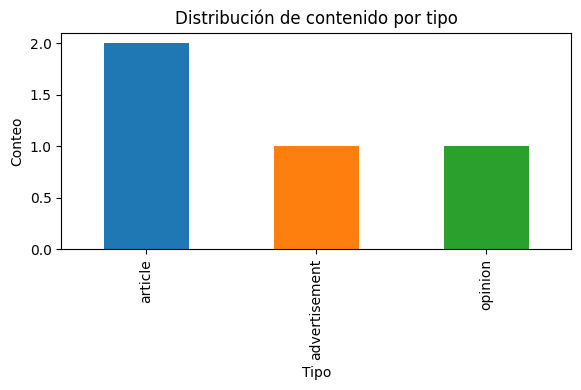

In [8]:
import matplotlib.pyplot as plt

counts = df["type"].value_counts()
plt.figure(figsize=(6,4))
counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"])
plt.title("Distribución de contenido por tipo")
plt.xlabel("Tipo")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()
